In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from enum import Enum, IntEnum

import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch import nn
from torchsummary import summary
import torch
print (f'torch.__version__: {torch.__version__}')
import tensorflow as tf
import cv2 as cv
from torchvision import transforms

import enums
import viz
import configuration
import customdataset
import transformers
import models
import feature_helpers
from utilmethods import create_output_folders, check_torch_mps_device, make_torch_deterministic

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import loguniform
from tqdm.notebook import tqdm

check_torch_mps_device()
device = 'cpu'
device = 'mps'

config = configuration.Configuration()
face_config = configuration.FaceConfig(config)
pose_config = configuration.PoseConfig(config)
feature_extractor = feature_helpers.FeatureExtractor(config, face_config, pose_config, tqdm)

LABELS_TO_INCLUDE = config.class_dict.keys()
# LABELS_TO_INCLUDE=[0,1,2,9]

# When num samples increases plotting PCA and TSNE can crash. So better to not run those cells during the main training.    
NUM_SAMPLES_TO_LOAD = 100
IMAGE_TYPES = [enums.ImageTypes.ORIGINAL,enums.ImageTypes.POSE, enums.ImageTypes.FACE]

torch.__version__: 1.13.0
tensor([1.], device='mps:0')


/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


## Load Data

In [4]:
%%time
# Load the data
data = feature_extractor.load_data(image_types=IMAGE_TYPES, shuffle=True, sample_type=enums.SampleType.TRAIN_VALIDATION,
                                   count_per_label=NUM_SAMPLES_TO_LOAD)
print(f'Loaded {data.shape[0]} samples.')


Loading 1000 samples:   0%|          | 0/1000 [00:00<?, ?samples/s]

Loaded 1000 samples.
CPU times: user 6.06 s, sys: 3.06 s, total: 9.12 s
Wall time: 7.38 s


In [5]:
%%time
features_list = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
y = data[enums.DataColumn.LABEL.value]
features_names = ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose']
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = features_list

Loading feature vectors:   0%|          | 0/1000 [00:00<?, ?images/s]

CPU times: user 558 ms, sys: 335 ms, total: 893 ms
Wall time: 1.83 s


## Dimensionality Reduction

In [6]:
# Helpers for vizualizing
def plot_PCA(X_list, names, n_components=2):
    pca_list, xpca_list = feature_extractor.get_PCA(X_list, n_components=n_components)
    plt.figure(figsize=(15,5))
    colors = ['b-', 'g-', 'r-', 'k-', 'y-']
    plot_labels = [f'{name} features' for name in names]
    for i in range(len(X_list)):
        plt.plot(np.cumsum(pca_list[i].explained_variance_ratio_), colors[i], label=plot_labels[i])
    plt.xticks(np.arange(n_components)+1)
    plt.yticks(np.linspace(0, 1, 8))
    plt.grid(visible=True)
    plt.xlabel('Number of components')
    plt.ylabel('Explained Variances')
    plt.legend()
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=None, rect=None)
    plt.show()

def plot_classes(X, y, ax, title, included_labels):
    colormap = plt.cm.tab20 #nipy_spectral #, Set1,Paired
    colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
    for k, label in enumerate(included_labels):
        if X.shape[1] == 2:
            ax.scatter(X[y==label, 0], X[y==label, 1], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
        else:
            ax.scatter(X[y==label, 0], X[y==label, 1], X[y==label, 2], alpha=0.5, facecolors=colorst[k], label=config.class_dict[label])
    ax.set_title(title)
    
def plot_components(features_list, X_pcas, X_tsnes, names, included_labels=LABELS_TO_INCLUDE):
    # project the features into 2 dimensions
    fig, ax = plt.subplots(nrows=len(features_list), ncols=2, figsize=(10,10))

    # y is the class labels
    for i in range(len(features_list)):
        plot_classes(X_pcas[i], y, ax[i,0], title=f'{names[i]} PCA', included_labels=LABELS_TO_INCLUDE)
        plot_classes(X_tsnes[i], y, ax[i,1], title=f'{names[i]} tSNE', included_labels=LABELS_TO_INCLUDE)
    
    handles, plot_labels = ax[0,0].get_legend_handles_labels()
    fig.legend(handles, plot_labels, loc='upper center')
    plt.tight_layout(pad=0.1, h_pad=None, w_pad=12, rect=None)
    plt.show()

Doing PCA(50):   0%|          | 0/5 [00:00<?, ?images/s]

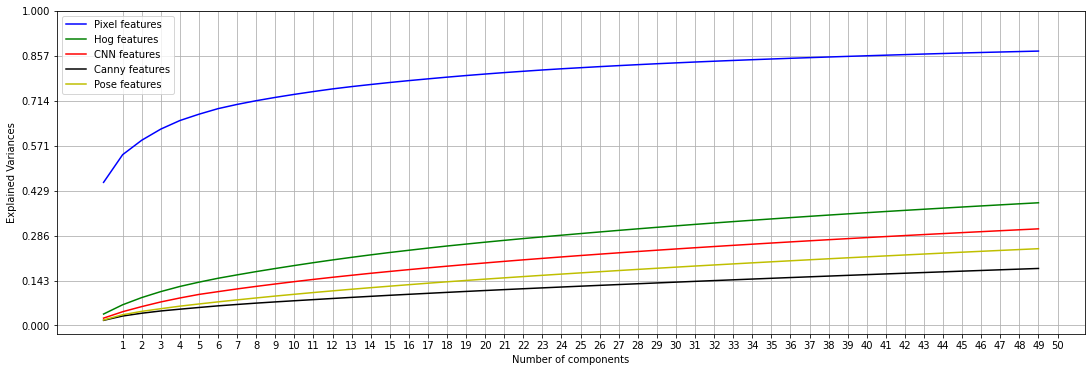

CPU times: user 5min 1s, sys: 1min 51s, total: 6min 53s
Wall time: 43.2 s


In [7]:
%%time
plot_PCA(features_list, features_names, n_components=50)

Doing PCA(2):   0%|          | 0/5 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/5 [00:00<?, ?images/s]

/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2

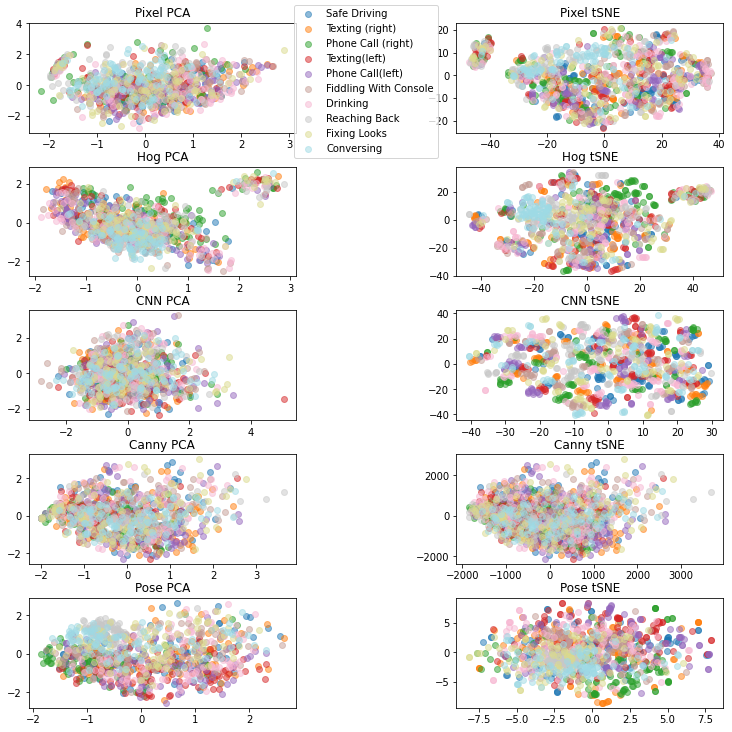

CPU times: user 7min 13s, sys: 2min 45s, total: 9min 59s
Wall time: 1min 11s


In [8]:
%%time
def visualize_components():
    pcas = feature_extractor.get_PCA([pixel_features, hog_features, cnn_features, canny_features, pose_features], n_components=2)[-1]
    tsnes = feature_extractor.get_tsne([pixel_features, hog_features, cnn_features, canny_features, pose_features], n_components=2)
    plot_components(features_list, 
                    pcas, 
                    tsnes,
                    ['Pixel', 'Hog', 'CNN', 'Canny', 'Pose'],
                    included_labels=LABELS_TO_INCLUDE)
visualize_components()

## KNN Classification

In [9]:
# Load feature vectors
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
X_pixels_pca, X_hog_pca, X_CNN_pca, X_canny_pca, X_pose_pca = feature_extractor.get_PCA(features_list, n_components=2)[-1]
X_pixels_tsne, X_hog_tsne, X_CNN_tsne, X_canny_tsne, X_pose_tsne = feature_extractor.get_tsne(features_list, n_components=2)
y = data['label']

Loading feature vectors:   0%|          | 0/1000 [00:00<?, ?images/s]

Doing PCA(2):   0%|          | 0/5 [00:00<?, ?images/s]

Doing tSNE(2):   0%|          | 0/5 [00:00<?, ?images/s]

/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/Users/yhkim/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2

In [10]:
def calc_accuracy(knn, pca, y, idx):
    knn.fit(pca, y)
    accuracy = 0
    for i in idx:
        label = knn.predict([pca[i,:]])
        if label[0] == y[i]:
            accuracy +=1
    return accuracy

def accuracies(n_samples):
    knn = KNeighborsClassifier(n_neighbors = 3)
    idx = np.random.choice(np.arange(len(y)), n_samples, replace=False)
    # print(y[idx])
    print(f'Accuracies from {n_samples} samples:')
    print('Pixel PCA Accuracy: ', calc_accuracy(knn, X_pixels_pca, y, idx)/n_samples)
    print('Pixel tSNE Accuracy: ', calc_accuracy(knn, X_pixels_tsne, y, idx)/n_samples)
    print('HOG PCA Accuracy: ', calc_accuracy(knn, X_hog_pca, y, idx)/n_samples)
    print('HOG tSNE Accuracy: ', calc_accuracy(knn, X_hog_tsne, y, idx)/n_samples)
    print('CNN PCA Accuracy: ', calc_accuracy(knn, X_CNN_pca, y, idx)/n_samples)
    print('CNN tSNE Accuracy: ', calc_accuracy(knn, X_CNN_tsne, y, idx)/n_samples)
    print('Canny PCA Accuracy: ', calc_accuracy(knn, X_canny_pca, y, idx)/n_samples)
    print('Canny tSNE Accuracy: ', calc_accuracy(knn, X_canny_tsne, y, idx)/n_samples)
    print('Pose PCA Accuracy: ', calc_accuracy(knn, X_pose_pca, y, idx)/n_samples)
    print('Pose tSNE Accuracy: ', calc_accuracy(knn, X_pose_tsne, y, idx)/n_samples)

print(f'Loaded {data.shape[0]} samples.')
print(f'hog_features:{hog_features.shape}, hog_features.min:{np.min(hog_features)}, hog_features.max:{np.max(hog_features)}')
print(f'pixel_features:{pixel_features.shape}, pixel_features.min:{np.min(pixel_features)}, pixel_features.max:{np.max(pixel_features)}')
print(f'cnn_features:{cnn_features.shape}, cnn_features.min:{np.min(cnn_features)}, cnn_features.max:{np.max(cnn_features)}')
print(f'canny_features:{canny_features.shape}, canny_features.min:{np.min(canny_features)}, canny_features.max:{np.max(canny_features)}')
print(f'pose_features:{pose_features.shape}, pose_features.min:{np.min(pose_features)}, pose_features.max:{np.max(pose_features)}')
print()
accuracies(100)

Loaded 1000 samples.
hog_features:(1000, 5776), hog_features.min:0.0, hog_features.max:1.0
pixel_features:(1000, 25600), pixel_features.min:0.0, pixel_features.max:0.9999000430107117
cnn_features:(1000, 2048), cnn_features.min:0.0, cnn_features.max:1.6075034141540527
canny_features:(1000, 25600), canny_features.min:0, canny_features.max:255
pose_features:(1000, 65536), pose_features.min:0.0, pose_features.max:0.6640035510063171

Accuracies from 100 samples:
Pixel PCA Accuracy:  0.53
Pixel tSNE Accuracy:  0.65
HOG PCA Accuracy:  0.51
HOG tSNE Accuracy:  0.76
CNN PCA Accuracy:  0.43
CNN tSNE Accuracy:  0.9
Canny PCA Accuracy:  0.51
Canny tSNE Accuracy:  0.45
Pose PCA Accuracy:  0.5
Pose tSNE Accuracy:  0.59


## Logistic Regression

In [11]:
# get the train and test split
[pixel_features, hog_features, cnn_features, canny_features, pose_features] = feature_extractor.load_feature_vectors(config.FEATURE_VECTORS_FOLDER, data['filename'], data['label'])
train_idx, val_idx = train_test_split(np.arange(len(y)), test_size=0.2, random_state=config.SEED)

Loading feature vectors:   0%|          | 0/1000 [00:00<?, ?images/s]

In [39]:
!pip install hyperopt

In [54]:
from hyperopt import STATUS_OK,rand, tpe, Trials, fmin, hp
from hyperopt.early_stop import no_progress_loss
from sklearn.model_selection import cross_val_score

# Input dict for hypteropt
opt_dict = {
    # 'logistic_regression': {
    #     'model': LogisticRegression,
    #     'params': {
    #         'penalty': 'l1',
    #         'solver': 'saga',
    #         'max_iter': 5000,
    #         'C': hp.loguniform('C', 1e-3, 1e5)
    #     }
    # },
    'random_forest': {
        'model': RandomForestClassifier,
        'params': {
                'max_depth': 2 + hp.randint('max_depth', 20),
                'n_estimators': 2 + hp.randint('n_estimators', 300),
                'n_jobs': 4
        }
    }
}

# Optimizer definition
def optimize(opt_dict, best_dict, X_train, y_train, max_evals = 50, random_state = config.SEED):
    """
        Runs hyperopt for all the models in opt_dict. Adds the best hyperparameter set for each model.
        Returns dictionary of best hyperparameter set.
    """
    # Define TPE algorithm for all optimizers
    tpe_algo = tpe.suggest

    # Iterate over opt_dict
    for k,v in opt_dict.items():
        ## Attributes
        model_name = k
        model = v['model']
        params = v['params']

        ## objective function definition
        def f(params):
            loss = None
            try:
                m = model(random_state = random_state, **params)
                loss = cross_val_score(m, X_train, y_train, scoring = 'neg_log_loss').mean()
            except: AttributeError

            return {'loss': -loss, 'status': STATUS_OK}

        ## Define trial space
        trials = Trials()

        print(f"Optimizing {k} model...")

        ## optimize
        best = fmin(
            fn = f,
            space = params,
            algo = tpe_algo,
            max_evals = max_evals,
            trials = trials,
            early_stop_fn=no_progress_loss(1e-10)
        )

        best_dict[model_name] = best
        print(f"Best hyperparameter set for {model_name} is {best}")
        print("\n")

    return best_dict

# scaler = StandardScaler()
# X_train = pose_features[train_idx, :].copy()
# y_train = y[train_idx].copy()
# X_val = pose_features[val_idx, :].copy()
# y_val = y[val_idx].copy()

# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)

# # Optimize and output best hyperparameter set for each model
# best_dict = optimize(opt_dict = opt_dict,
#                      best_dict = best_dict,
#                      X_train = X_train,
#                      y_train = y_train,
#                      max_evals = 100)
# best_dict

In [55]:
# {'random_forest': {'max_depth': 0, 'n_estimators': 17}}
# clf = RandomForestClassifier(random_state = config.SEED, n_jobs = 4, max_depth = 1, n_estimators = 3)
# clf.fit(X_train, y_train)
# y_pred = clf.predict(X_val)
# accuracy_score(y_val, y_pred)

In [56]:
def train_classifier(in_feat, in_y, in_train_idx, val_idx):
    # get the train and validation split
    X_train = in_feat[in_train_idx, :].copy()
    y_train = in_y[in_train_idx].copy()
    X_val = in_feat[val_idx, :].copy()
    y_val = in_y[val_idx].copy()

    # scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # classifier with cross validation
    best_dict = {}
    param_grid = {
        'logistic_regression': {
            'model': LogisticRegression,
            'params': {
                'penalty': 'elasticnet',
                'solver': 'saga',
                'max_iter': 5000,
                'C': hp.loguniform('C', 50, 200),
                'l1_ratio': hp.loguniform(0.3, 0.9)
            }
        },
        'random_forest': {
            'model': RandomForestClassifier,
            'params': {
                    'max_depth': 1 + hp.randint('max_depth', 20),
                    'n_estimators': 1 + hp.randint('n_estimators', 300),
                    'n_jobs': 4
            }
        }
    }
    # Optimize and output best hyperparameter set for each model
    best_dict = optimize(opt_dict = param_grid,
                         best_dict = best_dict,
                         X_train = X_train,
                         y_train = y_train,
                         max_evals = 100)
    clf_lr = LogisticRegression()
    clf_rf = RandomForestClassifier(random_state = config.SEED, **best_dict['random_forest'])
    clf_rf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    return accuracy_score(y_val, y_pred)

In [4]:
a = ['max_error', 'min_error', 'hello']
[x for x in a if 'error' in x]

['max_error', 'min_error']

In [57]:
def train_and_check(features, n_components, name, y, train_idx, val_idx):
    pbar = tqdm(desc=name, total=len(n_components) + 1, position=0, leave=True)
    acc = []
    for n in n_components:
        pbar.set_description(f'{name}: Computing PCA({n})')
        _, X = feature_extractor.get_PCA([features], n_components=n+1)
        acc.append(train_classifier(X[0], y, train_idx, val_idx))
        pbar.update(1)
    pbar.set_description(f'{name}: Training classifier')
    acc.append(train_classifier(features, y, train_idx, val_idx))
    pbar.update(1)
    pbar.close()
    return acc

# get accuracy with different features
n_components = [50, 100, 150, 200]
# print('Pixel Feature Accuracy')
# pixel_acc = train_and_check(pixel_features, n_components, 'Pixel', y, train_idx, val_idx)
print('Pose Feature Accuracy')
pose_acc = train_and_check(pose_features, n_components, 'Pose', y, train_idx, val_idx)

Pose Feature Accuracy


Pose:   0%|          | 0/5 [00:00<?, ?it/s]

Doing PCA(51):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [00:57<00:00,  1.73trial/s, best loss: 1.6864709539043723]
Best hyperparameter set for random_forest is {'max_depth': 13, 'n_estimators': 196}




Doing PCA(101):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 1.7796852055007588]
Best hyperparameter set for random_forest is {'max_depth': 15, 'n_estimators': 260}




Doing PCA(151):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13trial/s, best loss: 1.8330613242237692]
Best hyperparameter set for random_forest is {'max_depth': 13, 'n_estimators': 297}




Doing PCA(201):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 1.8683310477813209]
Best hyperparameter set for random_forest is {'max_depth': 13, 'n_estimators': 268}


Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [10:16<00:00,  6.16s/trial, best loss: 1.7892585670559853]
Best hyperparameter set for random_forest is {'max_depth': 18, 'n_estimators': 292}




In [58]:
print('CNN Feature Accuracy')
CNN_acc = train_and_check(cnn_features, n_components, 'CNN', y, train_idx, val_idx)

CNN Feature Accuracy


CNN:   0%|          | 0/5 [00:00<?, ?it/s]

Doing PCA(51):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:00<00:00,  1.65trial/s, best loss: 1.7385034265841655]
Best hyperparameter set for random_forest is {'max_depth': 17, 'n_estimators': 297}




Doing PCA(101):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:11<00:00,  1.41trial/s, best loss: 1.8044738777633864]
Best hyperparameter set for random_forest is {'max_depth': 18, 'n_estimators': 293}




Doing PCA(151):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 1.8640344185892221]
Best hyperparameter set for random_forest is {'max_depth': 16, 'n_estimators': 262}




Doing PCA(201):   0%|          | 0/1 [00:00<?, ?images/s]

Optimizing random_forest model...

100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 1.9087460618499805]
Best hyperparameter set for random_forest is {'max_depth': 17, 'n_estimators': 201}


Optimizing random_forest model...

100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:51<00:00,  4.11s/trial, best loss: 2.09619277555692]
Best hyperparameter set for random_forest is {'max_depth': 16, 'n_estimators': 259}




In [24]:
# pixel_tqdm = tqdm(prefix='Pixel', total=len(n_components) + 1, position=0, leave=True)
# pixel_acc = []
# for n in n_components:
#     pixel_tqdm.set_description(f'Computing PCA({n})')
#     _, X = feature_extractor.get_PCA([pixel_features], n_components=n+1)
#     pixel_acc.append(train_classifier(X[0], y, train_idx, val_idx))
#     pixel_tqdm.update(1)
# pixel_tqdm.set_description(f'Training calssifier')
# pixel_acc.append(train_classifier(pixel_features, y, train_idx, val_idx))
# pixel_tqdm.update(1)
# pixel_tqdm.close()

# print('Pose Feature Accuracy')
# pose_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([pose_features], n_components=n+1)
#   pose_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# pose_acc.append(train_classifier(pose_features, y, train_idx, val_idx))

# print('CNN Feature Accuracy')
# CNN_acc = []
# for n in range(n_components):
#   _, X = feature_extractor.get_PCA([CNN_features], n_components=n+1)
#   CNN_acc.append(train_classifier(X[0], y, train_idx, val_idx))
# CNN_acc.append(train_classifier(CNN_features, y, train_idx, val_idx))

/var/folders/fc/h9494d9n6bj037jj44550zmw0000gq/T/ipykernel_57061/3480572385.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


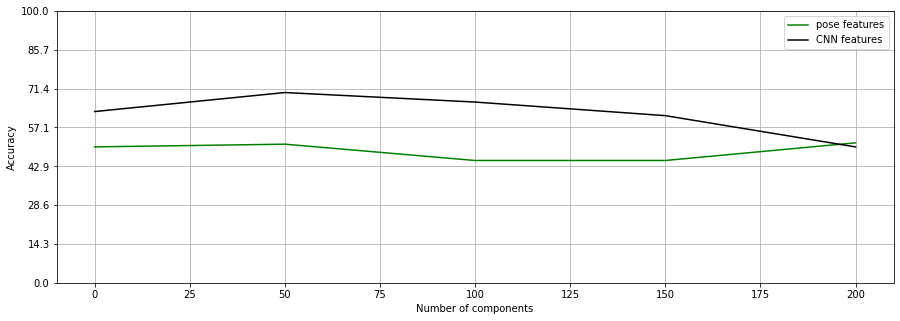

In [59]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
# plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
plt.plot(np.arange(5)*50, np.array(pose_acc)*100, 'g-', label='pose features')
plt.plot(np.arange(5)*50, np.array(CNN_acc)*100, 'k-', label='CNN features')

xtick_labels = [f'{i+1}' for i in n_components] + ['All']
# plt.xticks(np.arange(5)*50, labels=xtick_labels)
plt.yticks(np.linspace(0, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()

/var/folders/fc/h9494d9n6bj037jj44550zmw0000gq/T/ipykernel_26503/3480572385.py:10: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True)


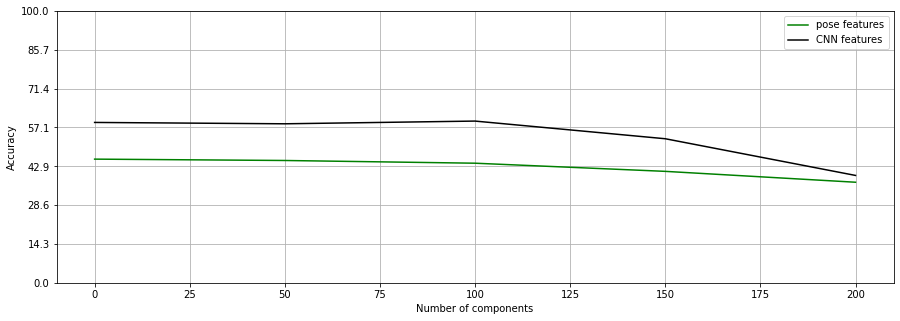

In [35]:
# plot the accuracy graph
plt.figure(figsize=(15,5))
# plt.plot(np.array(pixel_acc)*100, 'b-', label='pixel features')
plt.plot(np.arange(5)*50, np.array(pose_acc)*100, 'g-', label='pose features')
plt.plot(np.arange(5)*50, np.array(CNN_acc)*100, 'k-', label='CNN features')

xtick_labels = [f'{i+1}' for i in n_components] + ['All']
# plt.xticks(np.arange(5)*50, labels=xtick_labels)
plt.yticks(np.linspace(0, 100, 8))
plt.grid(b=True)
plt.xlabel('Number of components')
plt.ylabel('Accuracy')
plt.ylim([0, 100])
plt.legend()
plt.show()